# Sentiment based multi-index integrated scoring method to improve the accuracy of recommender system
reference: https://www.sciencedirect.com/science/article/pii/S0957417421005467#b0230
4.3. Multi-index integrated scoring method

1. **Measure User Consistency per Aspect**

    * For each user $u$ and aspect $a$, compute the Pearson correlation

      $$
      C_{u,a} = \mathrm{Pearson}(\{r_{u,i,a}\},\{s_{u,i,a}\}).
      $$  demonstrates more reliably on that aspect, all without any de-noising step.


2. **Derive an Adaptive Weight**

   * Define

     $$
       w_{u,i,a} = 1 - C'_{u,a}.
     $$
   * Interpretation:

     * **High consistency** ($C'\approx1$) → $w\approx0$ → default to the explicit rating.
     * **Low consistency** → $w$ larger → rely more on sentiment.


3. **Fuse Rating & Sentiment per Aspect**

   * Compute the final, blended score:

     $$
       r^*_{u,i,a}
       = w_{u,i,a}\,s_{u,i,a}
       + (1 - w_{u,i,a})\,r_{u,i,a}.
     $$
   * Each aspect gets its own adaptive mix of numeric rating and text-derived sentiment.

4. **Integrate into Recommendation**

   * Treat the fused vector $\{r^*_{u,i,1},\dots,r^*_{u,i,A}\}$ as the user’s multi-aspect preference.
   * Plug this vector into your downstream model (e.g. multi-task matrix factorization or neural recommender).


In [56]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# 1) Load your pre-split data
train_df = pd.read_csv("train_wide.csv")  
val_df   = pd.read_csv("test_wide.csv")
train_df


,username,beer_id,feel_predicted_rating,look_predicted_rating,smell_predicted_rating,taste_predicted_rating,feel_true_rating,look_true_rating,smell_true_rating,taste_true_rating
0,2beerdogs,286475,3.820000,3.790000,3.820000,3.840000,3.500000,3.750000,3.750000,3.500000
1,scootny,138765,3.940000,3.930000,3.940000,3.940000,4.000000,3.625000,4.000000,4.125000
2,Boilermaker88,2280,2.054000,2.043250,2.055000,2.063250,1.987500,2.300000,1.525000,1.518750
3,altgeeky1,25007,2.377692,2.352308,2.366154,2.377692,2.423077,2.807692,1.769231,1.884615
4,draheim,46983,3.997500,3.957500,4.007500,4.005000,3.937500,4.187500,4.187500,4.250000
...,...,...,...,...,...,...,...,...,...,...
21470,metter98,51153,4.043333,4.040000,4.060000,4.046667,4.083333,4.000000,4.416667,4.333333
21471,Gunslinger711,34146,3.844737,3.828947,3.843158,3.845789,3.921053,3.868421,3.934211,4.052632
21472,BEERchitect,9613,3.070000,3.010000,3.040000,3.040000,3.000000,3.250000,3.250000,3.000000
21473,budgood1,31057,1.510000,1.530000,1.520000,1.550000,1.500000,1.250000,1.500000,1.500000


In [58]:
import numpy as np
from scipy.stats import pearsonr

# 1) List your aspects
aspects = ['feel', 'look', 'smell', 'taste']

# 2) Define a tiny helper that takes two numpy arrays and returns C'
def cprime_from_arrays(tr, pr):
    if tr.std() == 0 or pr.std() == 0:
        # Euclidean-fallback
        dist = np.linalg.norm(tr - pr)
        return 1.0 / (1.0 + dist)
    corr = pearsonr(tr, pr)[0]
    return (corr + 1.0) / 2.0

# 3) For each aspect, compute one C' per user, then map it back onto each row
#    We'll also compute w and r_star in the same loop.
for asp in aspects:
    tcol = f'{asp}_true_rating'
    pcol = f'{asp}_predicted_rating'
    ccol = f'{asp}_C_prime'
    wcol = f'{asp}_w'
    rcol = f'{asp}_r_star'

    # 3a) Compute the per-user scalar C'
    #     groupby.apply returns a Series indexed by username
    c_per_user = (
        train_df
        .groupby('username')
        .apply(lambda g: cprime_from_arrays(g[tcol].values, g[pcol].values))
    )

    # 3b) Broadcast onto both train & val
    train_df[ccol] = train_df['username'].map(c_per_user)
    # for val, if a user never appeared in train, fill with the global mean
    global_mean = c_per_user.mean()
    val_df[ccol]   = val_df['username'].map(c_per_user).fillna(global_mean)

    # 3c) Compute adaptive weight w = 1 – C'
    train_df[wcol] = 1.0 - train_df[ccol]
    val_df  [wcol] = 1.0 - val_df  [ccol]

    # 3d) Fuse the scores
    train_df[rcol] = train_df[wcol] * train_df[pcol] + (1.0 - train_df[wcol]) * train_df[tcol]
    val_df  [rcol] = val_df  [wcol] * val_df  [pcol] + (1.0 - val_df  [wcol]) * val_df  [tcol]

keep = ['username','beer_id'] + [f'{asp}_r_star' for asp in aspects]
train_df = train_df[keep]
val_df   = val_df[keep]

C:\Users\胖头鱼\AppData\Local\Temp\ipykernel_12772\3926633288.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: cprime_from_arrays(g[tcol].values, g[pcol].values))
C:\Users\胖头鱼\AppData\Local\Temp\ipykernel_12772\3926633288.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: cprime_from_arrays(g[tcol].values, g[pcol].values))
C:\Users\胖头鱼\AppData\Local\Temp\ipykernel_12772\

In [59]:
train_df

,username,beer_id,feel_r_star,look_r_star,smell_r_star,taste_r_star
0,2beerdogs,286475,3.517751,3.760857,3.768435,3.551346
1,scootny,138765,3.984384,3.733674,3.991600,4.099598
2,Boilermaker88,2280,1.989741,2.295181,1.553805,1.566540
3,altgeeky1,25007,2.417028,2.725218,1.784229,1.894806
4,draheim,46983,3.949314,4.175389,4.156928,4.191522
...,...,...,...,...,...,...
21470,metter98,51153,4.079885,4.003453,4.388597,4.312034
21471,Gunslinger711,34146,3.915641,3.866922,3.926612,4.017181
21472,BEERchitect,9613,3.008361,3.226066,3.227799,3.004243
21473,budgood1,31057,1.500929,1.270215,1.500857,1.504986


In [60]:
val_df

,username,beer_id,feel_r_star,look_r_star,smell_r_star,taste_r_star
0,johnniemarg,9319,3.001225,3.949256,3.888750,3.977268
1,Brolo75,207537,4.007071,4.033426,4.234354,4.222896
2,Thehuntmaster,77779,2.012664,2.625627,2.248818,1.535139
3,Citadel82,29977,4.015398,4.011260,4.489105,4.471402
4,MattyG85,105784,4.360996,4.346861,4.247655,4.366067
...,...,...,...,...,...,...
5364,DIM,24905,3.897901,3.533755,3.897154,4.072123
5365,mfnmbvp,16807,3.712364,3.905960,4.099634,4.294318
5366,PhillyStyle,41505,3.146118,3.350885,3.221402,3.078893
5367,davidperez,74804,3.981646,3.847039,3.844615,3.707253


# user-based-collaborative-filtering

In [70]:
aspects = ['feel', 'look', 'smell', 'taste']
train_df['overall_r_star'] = train_df[[f'{asp}_r_star' for asp in aspects]].mean(axis=1)
val_df  ['overall_r_star'] = val_df  [[f'{asp}_r_star' for asp in aspects]].mean(axis=1)
train_df

C:\Users\胖头鱼\AppData\Local\Temp\ipykernel_12772\3335527731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['overall_r_star'] = train_df[[f'{asp}_r_star' for asp in aspects]].mean(axis=1)


,username,beer_id,feel_r_star,look_r_star,smell_r_star,taste_r_star,overall_r_star
0,2beerdogs,286475,3.517751,3.760857,3.768435,3.551346,3.649597
1,scootny,138765,3.984384,3.733674,3.991600,4.099598,3.952314
2,Boilermaker88,2280,1.989741,2.295181,1.553805,1.566540,1.851317
3,altgeeky1,25007,2.417028,2.725218,1.784229,1.894806,2.205320
4,draheim,46983,3.949314,4.175389,4.156928,4.191522,4.118288
...,...,...,...,...,...,...,...
21470,metter98,51153,4.079885,4.003453,4.388597,4.312034,4.195992
21471,Gunslinger711,34146,3.915641,3.866922,3.926612,4.017181,3.931589
21472,BEERchitect,9613,3.008361,3.226066,3.227799,3.004243,3.116617
21473,budgood1,31057,1.500929,1.270215,1.500857,1.504986,1.444247


In [79]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import GridSearchCV

#reader + load Dataset —
reader = Reader(rating_scale=(train_df['overall_r_star'].min(),
                              train_df['overall_r_star'].max()))
data = Dataset.load_from_df(
    train_df[['username','beer_id','overall_r_star']],
    reader
)

#fine‐tune with GridSearchCV —
param_grid = {
    'k':       [5, 10, 20, 40],
    'min_k':   [1, 2, 5],
    'sim_options': {
        'name':       ['pearson','cosine'],
        'user_based': [True]
    }
}
gs = GridSearchCV(
    KNNBasic,
    param_grid,
    measures=['rmse'],
    cv=3,
    n_jobs=1
)
gs.fit(data)

print("Best RMSE score:",    gs.best_score['rmse'])
print("Best parameters:",    gs.best_params['rmse'])

#build final Trainset and final algo with best params —
trainset = data.build_full_trainset()
best_opts = gs.best_params['rmse']
algo = KNNBasic(
    k=best_opts['k'],
    min_k=best_opts['min_k'],
    sim_options=best_opts['sim_options']
)

#fit on the full trainset —
algo.fit(trainset)

#prepare your val_test_list as before —
val_test_list = list(
    val_df[['username','beer_id','overall_r_star']]
      .itertuples(index=False, name=None)
)

#finally test
predictions = algo.test(val_test_list)


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Compu

## Evaluation

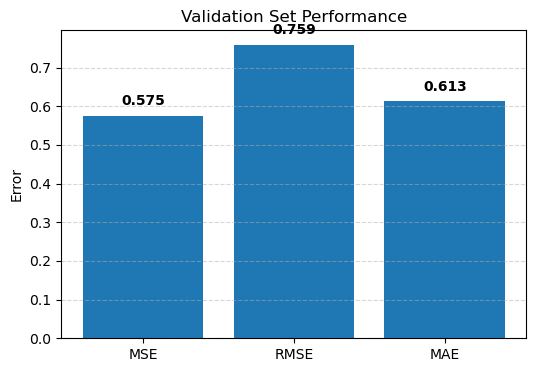

In [97]:
from surprise.accuracy import mse, rmse, mae
import matplotlib.pyplot as plt

mse_score  = mse(predictions, verbose=False)
rmse_score = rmse(predictions, verbose=False)
mae_score  = mae(predictions, verbose=False)

metrics = ['MSE','RMSE','MAE']
scores  = [mse_score, rmse_score, mae_score]
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(metrics, scores)
for i, v in enumerate(scores):
    ax.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontweight='bold')
ax.set_ylabel("Error"); ax.set_title("Validation Set Performance")
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [95]:
# Example
def recommend_user(algo, trainset, user_id, N=5):
    """
    Returns a list of (item_id, estimated_score) for the top-N
    items the user has not yet rated.
    """
    try:
        inner_uid = trainset.to_inner_uid(user_id)
    except ValueError:
        return []  # user not in trainset

    # items the user has already rated
    seen_iids = {iid for (iid, _) in trainset.ur[inner_uid]}
    # map all internal iids back to raw ids
    raw_iids = [trainset.to_raw_iid(i) for i in trainset.all_items()]

    # candidates = those the user hasn't seen
    candidates = [iid for iid in raw_iids if trainset.to_inner_iid(iid) not in seen_iids]

    # predict each candidate
    scores = [(iid, algo.predict(user_id, iid).est) for iid in candidates]
    # sort by score descending and take top N
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:N]

for user in ['Boilermaker88', 'budgood1', 'draheim']:
    top5 = recommend_user(algo, trainset, user, N=5)
    print(f"\nTop-5 recommendations for {user}:")
    for beer_id, score in top5:
        print(f"  Beer {beer_id}: {score:.3f}")


Top-5 recommendations for Boilermaker88:
  Beer 179485: 4.811
  Beer 18850: 4.761
  Beer 91860: 4.759
  Beer 80653: 4.705
  Beer 1144: 4.703

Top-5 recommendations for budgood1:
  Beer 1144: 4.703
  Beer 61361: 4.702
  Beer 44743: 4.693
  Beer 111616: 4.665
  Beer 107838: 4.618

Top-5 recommendations for draheim:
  Beer 44743: 4.693
  Beer 47088: 4.689
  Beer 77227: 4.683
  Beer 47546: 4.606
  Beer 54351: 4.580
